# **Setting up Gymnasium**

In [95]:
import gymnasium as gym
env = gym.make("CartPole-v1")

observation, info = env.reset(seed=42)
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

# **Q-Learning on Blackjack**

### **Blackjeck** 

**Objective:** To win, your card sum should be greater than the dealers without exceeding 21. 

**The card values are:**
- Face cards (Jack, Queen, King) have a point value of 10.
- Aces can either count as 11 (called a ‘usable ace’) or 1.
- Numerical cards (2-9) have a value equal to their number.

**Action Space:** The action shape is (1,)
- 0: Stick --> the player takes no more cards
- 1: Hit --> the player will be given another card

**Observation Space:**
returned as (int(), int(), int()) 3-tuple.
1. the player’s current sum
2. value of the dealer’s one showing card (1-10 where 1 is ace)
3. whether the player holds a usable ace (0 or 1)

**Starting State (Initialised):**
|        Observation          | Min | Max |
|:---------------------------:|:---:|:---:|
|     Player current sum      |  4  | 12  |
| Dealer showing card value   |  2  | 11  |
|         Usable Ace          |  0  |  1  |

**Rewards:**
- win game: +1
- lose game: -1
- draw game: 0
- win game with natural blackjack: +1.5 (if *natural* is True) +1 (if *natural* is False)

**Episode End:**
- The player hits and the sum of hand exceeds 21.
- The player sticks.

**Arguments:**
- **natural=False:** Whether to give an additional reward for natural blackjack, i.e. starting with an ace and ten (sum is 21).
- **sab=False:** If sab is True, the keyword argument natural will be ignored.


In [96]:
# import image module 
from IPython.display import Image 
  
# get the image 
Image(url="blackjack_AE_loop.jpg") 

### **Imports and Environment Setup**

In [97]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

In [98]:
# Other possible environment configurations are:

env = gym.make('Blackjack-v1', natural=True, sab=False)
# Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

env = gym.make('Blackjack-v1', natural=False, sab=False)
# Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.

### **Observing the environment**

1. ***env.reset()*** to start an episode, resets the environment to a starting position and returns an initial observation. 
2. ***done = False*** useful later to check if a game is terminated (i.e., the player wins or loses).

In [99]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

### **Executing an action**

use the ***env.step(action)*** function to interact with the environment. It returns four useful variables

- **next_state:** This is the observation that the agent will receive after taking the action.
- **reward:** This is the reward that the agent will receive after taking the action.
- **terminated:** This is a boolean variable that indicates whether or not the environment has terminated.
- **truncated:** This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
- **info:** This is a dictionary that might contain additional information about the environment.

In [100]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

### **Building an agent**

build a Q-learning agent to solve Blackjack-v1. One possible solution is the epsilon-greedy strategy

In [101]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

The agent play one episode and then update it’s Q-values after each episode.

In [102]:
# hyperparameters
learning_rate = 0.01
n_episodes = 500_0000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

let’s train! 

If you want to converge to the optimal policy, try increasing the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).

In [103]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 5000000/5000000 [08:50<00:00, 9421.21it/s] 


### **Visualizing the training**

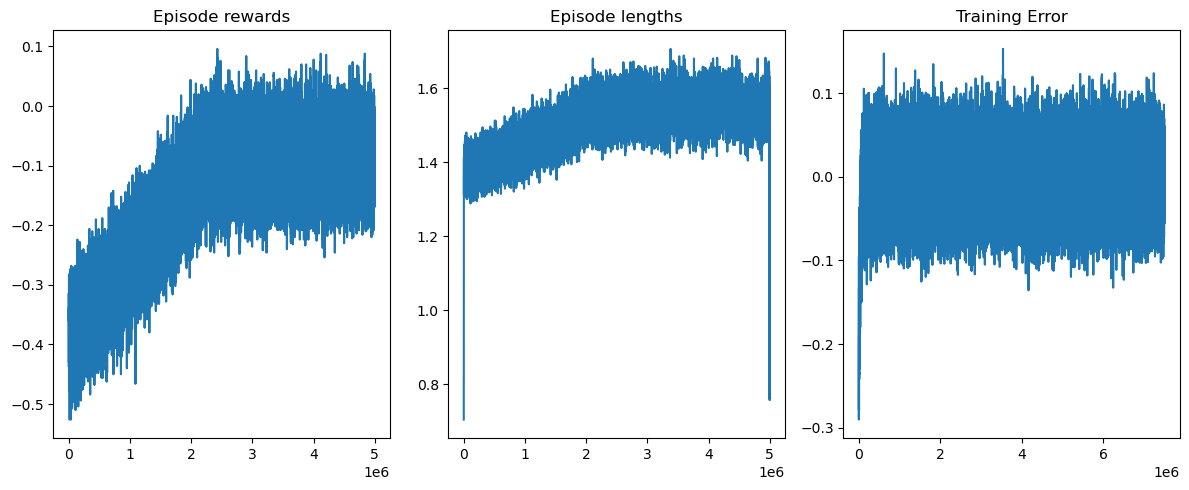

In [104]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

### **Visualising the policy**

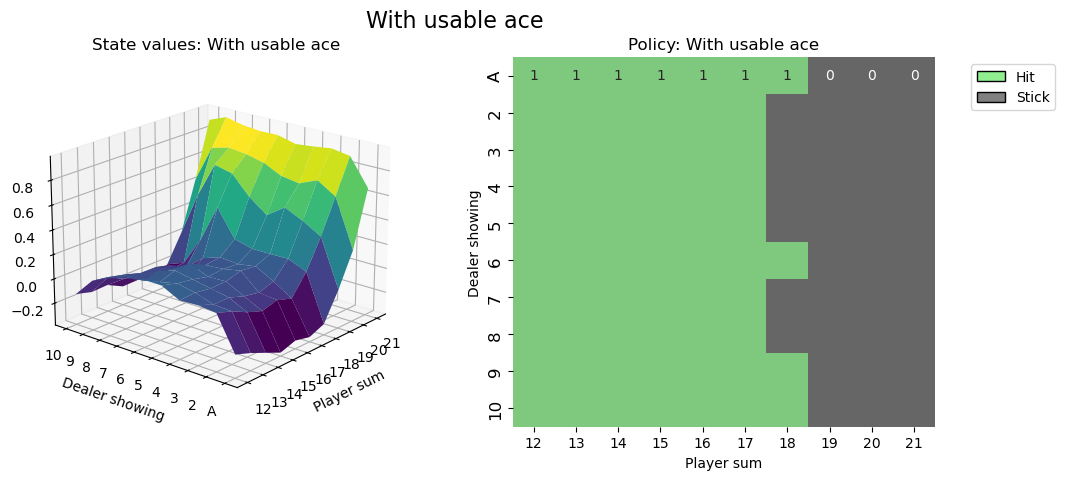

In [105]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [106]:
state_value = defaultdict(float)
policy = defaultdict(int)
for obs, action_values in agent.q_values.items():
    state_value[obs] = float(np.max(action_values))
    policy[obs] = int(np.argmax(action_values))


print(policy)

defaultdict(<class 'int'>, {(13, 7, 0): 1, (11, 10, 0): 1, (17, 6, 0): 0, (20, 10, 0): 0, (14, 10, 0): 1, (6, 10, 0): 1, (21, 10, 0): 0, (21, 3, 1): 0, (16, 10, 0): 0, (30, 10, 0): 0, (16, 10, 1): 1, (13, 10, 1): 1, (26, 10, 0): 0, (9, 10, 0): 1, (20, 3, 0): 0, (8, 10, 0): 1, (22, 10, 0): 0, (15, 10, 0): 1, (18, 7, 0): 0, (29, 3, 0): 0, (19, 6, 0): 0, (6, 9, 0): 1, (21, 5, 0): 0, (16, 5, 0): 0, (23, 5, 0): 0, (29, 4, 0): 0, (20, 4, 0): 0, (12, 6, 0): 1, (11, 6, 0): 1, (24, 6, 0): 0, (17, 10, 0): 0, (21, 6, 1): 0, (18, 2, 0): 0, (15, 2, 0): 0, (19, 9, 0): 0, (18, 10, 0): 0, (12, 10, 0): 1, (28, 10, 0): 0, (12, 7, 0): 1, (12, 5, 0): 1, (14, 10, 1): 1, (14, 7, 0): 1, (19, 7, 0): 0, (9, 7, 0): 1, (20, 2, 0): 0, (16, 9, 0): 0, (13, 9, 0): 1, (7, 7, 0): 1, (15, 7, 0): 1, (9, 1, 0): 1, (10, 7, 0): 1, (18, 6, 0): 0, (8, 6, 0): 1, (23, 6, 0): 0, (19, 1, 0): 0, (15, 1, 0): 1, (14, 6, 0): 0, (9, 6, 0): 1, (25, 7, 0): 0, (17, 7, 0): 0, (12, 2, 0): 1, (22, 8, 0): 0, (12, 8, 0): 1, (20, 10, 1): 0, (

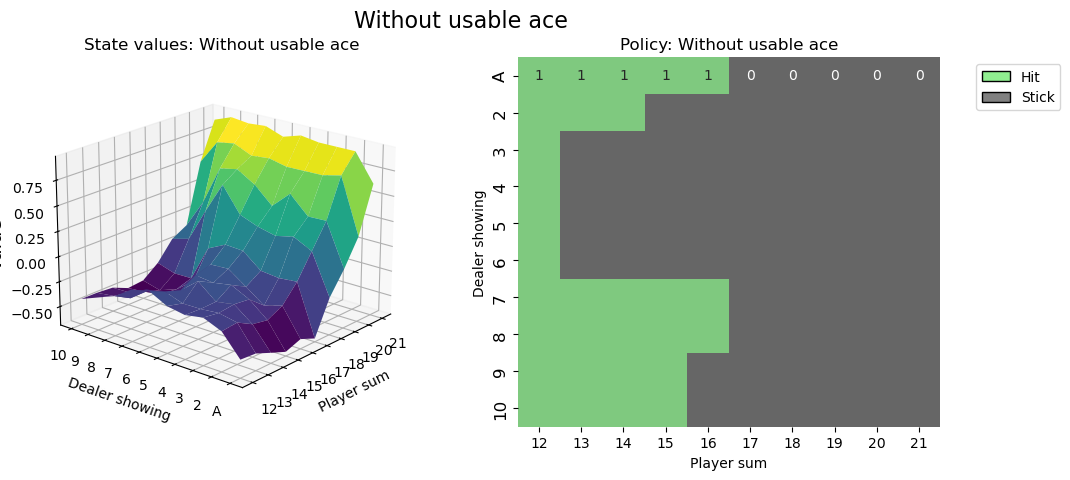

In [107]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [108]:
state_value = defaultdict(float)
policy = defaultdict(int)
for obs, action_values in agent.q_values.items():
    state_value[obs] = float(np.max(action_values))
    policy[obs] = int(np.argmax(action_values))


print(policy)

defaultdict(<class 'int'>, {(13, 7, 0): 1, (11, 10, 0): 1, (17, 6, 0): 0, (20, 10, 0): 0, (14, 10, 0): 1, (6, 10, 0): 1, (21, 10, 0): 0, (21, 3, 1): 0, (16, 10, 0): 0, (30, 10, 0): 0, (16, 10, 1): 1, (13, 10, 1): 1, (26, 10, 0): 0, (9, 10, 0): 1, (20, 3, 0): 0, (8, 10, 0): 1, (22, 10, 0): 0, (15, 10, 0): 1, (18, 7, 0): 0, (29, 3, 0): 0, (19, 6, 0): 0, (6, 9, 0): 1, (21, 5, 0): 0, (16, 5, 0): 0, (23, 5, 0): 0, (29, 4, 0): 0, (20, 4, 0): 0, (12, 6, 0): 1, (11, 6, 0): 1, (24, 6, 0): 0, (17, 10, 0): 0, (21, 6, 1): 0, (18, 2, 0): 0, (15, 2, 0): 0, (19, 9, 0): 0, (18, 10, 0): 0, (12, 10, 0): 1, (28, 10, 0): 0, (12, 7, 0): 1, (12, 5, 0): 1, (14, 10, 1): 1, (14, 7, 0): 1, (19, 7, 0): 0, (9, 7, 0): 1, (20, 2, 0): 0, (16, 9, 0): 0, (13, 9, 0): 1, (7, 7, 0): 1, (15, 7, 0): 1, (9, 1, 0): 1, (10, 7, 0): 1, (18, 6, 0): 0, (8, 6, 0): 1, (23, 6, 0): 0, (19, 1, 0): 0, (15, 1, 0): 1, (14, 6, 0): 0, (9, 6, 0): 1, (25, 7, 0): 0, (17, 7, 0): 0, (12, 2, 0): 1, (22, 8, 0): 0, (12, 8, 0): 1, (20, 10, 1): 0, (

In [109]:
print(policy_grid)

[[1 1 1 1 1 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]]


# **Exploring various learning algorithms**

### **Implementing MC Control**

In [ ]:
class BlackjackAgent_v2:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)